# Mini-Batch GD and How Adverserial Examples affects its Performance

### Overview of this Notebook: <br>
#### 1. Import of Python libraries and the dataset<br>
#### 2. Tuning of the Hyperparameters of the Mini-Batch Optimiser<br>
#### 3. Training a Naive Model<br>
#### 4. Evaluate the Attack against the Naive Model<br>
#### 5. Training a Robust Model <br>
#### 6. Evaluate the Attack against the Robust Model <br>
#### 7. Comparision of the two performances <br>

## Begin by importing the relevant libraries

In [1]:
from adversary import attack, protect
from net import Net
import numpy as np
from torch.optim import Optimizer
import torch
from training import training, testing, accuracy, tune_optimizer
from minibatch import MiniBatchOptimizer
import matplotlib.pyplot as plt
from data_utils import get_mnist, build_data_loaders
import json
from pathlib import Path
import random


## Get Data and Setup

In [2]:
use_cuda = True
device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
train_dataset, test_dataset = get_mnist(normalize=True)

In [3]:
epsilons = np.arange(0, 0.5, 0.05)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10
batch_size = 16

## Hyperparameter Tuning

## Train the Naive Model

In [4]:
learning_rate = 0.01
decreasing_lr = False

### Create Data Loaders with the set Batch Size and the Model
#### The layer setup is in the net.py file

In [5]:
net_naive = Net().to(device)
train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)

### Train and Test

In [6]:
mini_opt_naive = MiniBatchOptimizer(net_naive.parameters(), lr=learning_rate, decreasing_lr=decreasing_lr)
loss_train, acc_train = training(net_naive, train_loader, mini_opt_naive, criterion, accuracy, epochs=epochs, device=device)
loss_test, acc_test = testing(net_naive, test_loader, criterion, accuracy, device=device)

Launching training on cuda
batch 100	loss = 2.011	acc = 0.4375
batch 200	loss = 0.7144	acc = 1.0
batch 300	loss = 0.5136	acc = 0.875
batch 400	loss = 0.2885	acc = 0.9375
batch 500	loss = 0.4004	acc = 0.875
batch 600	loss = 0.4047	acc = 0.875
batch 700	loss = 0.1879	acc = 0.9375
batch 800	loss = 0.3543	acc = 0.875
batch 900	loss = 0.2395	acc = 0.9375
batch 1000	loss = 0.4126	acc = 0.8125
batch 1100	loss = 0.3235	acc = 0.9375
batch 1200	loss = 0.2709	acc = 0.9375
batch 1300	loss = 0.2801	acc = 0.875
batch 1400	loss = 0.01993	acc = 1.0
batch 1500	loss = 0.05095	acc = 1.0
batch 1600	loss = 0.08244	acc = 1.0
batch 1700	loss = 0.1972	acc = 0.9375
batch 1800	loss = 0.1429	acc = 0.9375
batch 1900	loss = 0.03114	acc = 1.0
batch 2000	loss = 0.08141	acc = 1.0
batch 2100	loss = 0.0822	acc = 1.0
batch 2200	loss = 0.09227	acc = 0.9375
batch 2300	loss = 0.007254	acc = 1.0
batch 2400	loss = 0.0629	acc = 1.0
batch 2500	loss = 0.09838	acc = 1.0
batch 2600	loss = 0.02177	acc = 1.0
batch 2700	loss = 0.065

## Attack Naive Model

In [7]:
accuracy_naive= []
losses_naive= []

for eps in epsilons:
    loss_attack, acc_attack  = attack(net_naive, criterion, test_loader, epsilon=eps, device=device)
    accuracy_naive.append(acc_attack)
    losses_naive.append(loss_attack)

Epsilon: 0.00	Test Accuracy = 0.962
Epsilon: 0.05	Test Accuracy = 0.956
Epsilon: 0.10	Test Accuracy = 0.948
Epsilon: 0.15	Test Accuracy = 0.936
Epsilon: 0.20	Test Accuracy = 0.921
Epsilon: 0.25	Test Accuracy = 0.900
Epsilon: 0.30	Test Accuracy = 0.870
Epsilon: 0.35	Test Accuracy = 0.826
Epsilon: 0.40	Test Accuracy = 0.765
Epsilon: 0.45	Test Accuracy = 0.689


## Train the Robust Model

In [8]:
robust_net = Net().to(device)
protect_epochs = epochs
protect_lr = learning_rate
protect_bz = batch_size
protect_dec_lr = decreasing_lr
prot_train_loader, prot_test_loader = build_data_loaders(train_dataset, test_dataset, protect_bz)
mini_opt_proc = MiniBatchOptimizer(robust_net.parameters(), lr=protect_lr, decreasing_lr=protect_dec_lr)

### Call the protect function to make the model robust

In [9]:
robust_net = protect(robust_net, mini_opt_proc, criterion, prot_train_loader, prot_test_loader, device=device, epochs=protect_epochs)

Epoch 0.00 | Test accuracy: 0.96160
Epoch 1.00 | Test accuracy: 0.97350
Epoch 2.00 | Test accuracy: 0.97790
Epoch 3.00 | Test accuracy: 0.98040
Epoch 4.00 | Test accuracy: 0.98230
Epoch 5.00 | Test accuracy: 0.98290
Epoch 6.00 | Test accuracy: 0.98400
Epoch 7.00 | Test accuracy: 0.98440
Epoch 8.00 | Test accuracy: 0.98530
Epoch 9.00 | Test accuracy: 0.98630
training took 139.6 s


## Attack the Robust Model

In [10]:
accuracy_robust = []
losses_robust = []

for eps in epsilons:
    loss_attack, acc_attack = attack(robust_net, criterion, prot_train_loader, eps, device=device)
    accuracy_robust.append(acc_attack)
    losses_robust.append(loss_attack)

Epsilon: 0.00	Test Accuracy = 0.995
Epsilon: 0.05	Test Accuracy = 0.994
Epsilon: 0.10	Test Accuracy = 0.992
Epsilon: 0.15	Test Accuracy = 0.990
Epsilon: 0.20	Test Accuracy = 0.987
Epsilon: 0.25	Test Accuracy = 0.983
Epsilon: 0.30	Test Accuracy = 0.975
Epsilon: 0.35	Test Accuracy = 0.964
Epsilon: 0.40	Test Accuracy = 0.945
Epsilon: 0.45	Test Accuracy = 0.918


## Comparative Analysis of the Two Models

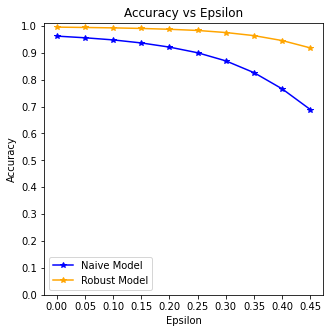

In [12]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracy_naive, "*-", c='blue', label='Naive Model')
plt.plot(epsilons, accuracy_robust, "*-", c='orange', label='Robust Model')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.5, step=0.05))

plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend();